# Home Depot Search Relevance
In this Kaggle competition, sponsored by Home Depot, participants were challenged to utilize a set of real customer search terms to predict how relevant they were to the particular product that Home Depot's website returned as a result. The relevance number would range from 1 (not relevant at all) to 3 (very relevant). Each search-term/product pair was evaluated by at least three real human people and the average of those values is what we will need to predict. 

## Initializations and Reusable Functions

In [1]:
#Show any plotted graphs within the notebook
% matplotlib inline

import sys
import re, collections

import pandas as pd #Data manipulation library
import numpy as np #Numerical analysis and linear algebra library

# Matplotlib provides the ability to plot figures and charts in python
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# sklearn provides various scientific functionality as well as machine learning models for data analysis
import sklearn 

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.cross_validation import KFold, StratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer #to create a bag of words out of our text
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.decomposition import TruncatedSVD

# Import the models we will be using as the base composition of our final predictive ensemble model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor

# eXtreme Gradient boosting library. Faster, more efficient, and more effective implementation of
# gradient boosting modeling
import xgboost
from xgboost import XGBClassifier, XGBRegressor

import string
from string import maketrans

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import HTMLParser
html_parser = HTMLParser.HTMLParser()


# miscellaneous libraries to help keep track of code run time, various math operations etc
import datetime
import time
import math
import itertools



### Functions :
** 1) RMSE (Root Mean Squared Error)<br>
2) cv_score <br>
3) do_GridsearchCV <br>
4) replaceAll <br>
5) addSpaces <br>
6) spellCheck <br>
7) cleanText <br>
8) clean_my_predictions (currently not used) <br>
9) compareWordHits
**


In [2]:
# Calculate the Root Mean Squared Error of a given prediction
# Use the "make_scorer" function from SKLearn to build your own "root" MSE scorer to be used in other functions
def RMSE(yTrue, yPred):
    return math.sqrt(mean_squared_error(yTrue,yPred))

RootMSE = make_scorer(RMSE, greater_is_better = False)

In [3]:
##########################
# function: cv_score

# Description:
# Do a 5 fold cross validation to calculate RMSE of the current model

# Input Parameters:
# clf - the sklearn model being cross-validated
# x - data matrix containing the features used to train models/predict outcomes
# y - target variable

# Return value:
# The average log_loss score achieved from 5 train/test iterations
##########################
def cv_score(clf, x, y):
    nfolds = 5
    score = 0
    for train, test in KFold(y.size, n_folds = nfolds ):
        xTrain = x[train]
        yTrain = y[train]
        xTest = x[test]
        yTest = y[test]
        
        clf.fit(xTrain, yTrain)
        predictions = clf.predict(xTest)
        score += math.sqrt(mean_squared_error(yTest, predictions))
    
    return score/nfolds
        

In [4]:
##########################
# function: do_GridsearchCV

# Description:
# Use cross-validated GridSearch to find best model parameters which optimizes our scoring objective

# Input Parameters:
# clf - the sklearn model being cross-validated
# params - dictionary of parameter names and their respective parameter values to be tested for optimality 
# scorer - the scoring function that the GridSearch will try to optimize (minimizing log_loss in our current case)
# xTrain - data matrix containing the features used to train models/predict outcomes
# yTrain - target variable
# folds - number of folds to be used during the cross-validation process

# Return values:
# clf - optimized estimator model
# clf.grid_scores_ - the paramater combos tested and their resulting score
# clf.best_params_ - the best scoring paramater combo
# clf.best_score_ - the best score achieved from the best params
##########################

def do_GridsearchCV(clf, params, scorer, xTrain, yTrain, folds = 5):
    startTime = time.time()
    clf = GridSearchCV(clf, param_grid = params, scoring = scorer, cv = folds)
    clf.fit(xTrain, yTrain)
    training_acc = clf.score(xTrain, yTrain)
    print "Training Accuracy: %0.2f" % training_acc
    print clf.grid_scores_, clf.best_params_, clf.best_score_
    print "\nTime GridSearchCV took to run: %r minutes" % ((time.time()-startTime)/60)

    return clf, clf.grid_scores_, clf.best_params_, clf.best_score_

In [5]:
##########################
# function: replaceAll

# Description:
# Replace all of the "search" terms with the "replace" values in a given sentence

# Input Parameters:
# sentence - the sentence upon which work will be done
# search - the term to be replaced
# replace - the new term to replace the original one

# Return values:
# sentence - return the amended sentence
##########################
def replaceAll(sentence, search, replace):
    for old, new in zip(search, replace):
        sentence = sentence.replace(old, new)
    return sentence

In [6]:
############################
# the product descriptions provided by HomeDepot are not properly spaced, 
# therefore, for each bullet point in a given product's attributes, add a space before it
############################
def addSpaces(row):
    spaceWords = []
    #for each bullet available for the currently given product...
    for bullet in bulletPoints[bulletPoints.product_uid == row.product_uid].value:
        spaceWords.append(bullet.split(" ")[0])   #take the first word in each bullet
    
    #append a space to the beginning of each word in 'spaceWords'
    newWords = ["".join(pair) for pair in (zip(len(spaceWords)*" ", spaceWords ))]
    return replaceAll(row.product_description,spaceWords, newWords)

In [7]:
##################
# using a generic spell-check algorithm found online, take a sentence and correct as many mistakes as possible
##################
def spellCheck(sentence):
    for word in sentence.split():
        newWord = correct(word)
        sentence = sentence.replace(word, newWord)
    return sentence

In [8]:
##################
# take a given sentence and "clean" each word based on the following steps
##################
def cleanText(sentence):

    # 1) remove HTML tags
    try:
        sentence = html_parser.unescape(sentence).encode('ascii', 'ignore')
    except Exception:
        sys.exc_clear()

    # 2) make everything lower case
    sentence = sentence.lower()
    # 3) remove weblinks and URLs
    for word in sentence.split():
        if ("www" in word) or ("http" in word):
            sentence = sentence.replace(word, "")

    # 4) remove English language contractions 
    bigContractions = {"don't":"do not", "won't":"will not"}
    sentence = replaceAll(sentence, bigContractions.keys(), bigContractions.values())
    smallContractions = {"'em": " them", "'d" : " would", "'ll": " will","'m": " am", "'n":"ing", 
                         "n't":" not",  "'ve":" have" }
    sentence = replaceAll(sentence, smallContractions.keys(), smallContractions.values())
    
    # 5) get rid of unwanted punctations, keeping ("-" and "/") because they are often used in sizing
    exclude = string.punctuation
    exclude = exclude.replace('-/', '')
    #trantab = maketrans(exclude, ""*len(exclude))
    sentence = sentence.translate(None, exclude)
    
    # 6) get rid of english stop words as provided by NLTK
    stop = stopwords.words('english')
    sentence = replaceAll(sentence, stop, ""*len(stop) )
    
    # 7) Stem words using Porter Stemmer from NLTK
    try:
        stemmer = PorterStemmer()
        stemmedWords = [stemmer.stem(word) for word in sentence.split()]
        sentence = " ".join(stemmedWords).encode('ascii', 'ignore')
    except Exception:
        sys.exc_clear()
    
    return sentence

In [9]:
##################
# Assuming a set number of human evaluators who would've provided a score, create a set of possible
# averages that your predictions should be. Then you can alter your prediction to the nearest possibility
#################
def clean_my_prediction(predictions):
    # Create a list of possible outcomes assuming three to five people providing training scores

    #three = np.unique([round(np.asarray(i).mean(),2) for i in itertools.combinations_with_replacement(range(4),3)])
    #four = np.unique([round(np.asarray(i).mean(),2) for i in itertools.combinations_with_replacement(range(4),4)])
    #five = np.unique([round(np.asarray(i).mean(),2) for i in itertools.combinations_with_replacement(range(4),5)])
    #train = trainData.relevance.unique()
    #possibleScores = np.unique(np.concatenate((three,train), axis = 0))
    #possibleScores = three

    returnValues = []
    for i in predictions:
        returnValues.append(min(possibleScores,key = lambda x: abs(x-i)))
    
    return returnValues

In [10]:
###################
# Find out the proportion of product title words are in the search terms, as well as proportion of the search terms
# are in the product title
#################
def compareWordHits(row):
    prodWordMatch = 0.0
    searchWordMatch = 0.0
    for prodWord in row.product_title.split(" "):
        for searchWord in row.search_term.split(" "):
            if (float(distance(prodWord,searchWord))/max(len(prodWord),len(searchWord))) < 0.20:
                prodWordMatch += 1.0
                searchWordMatch += 1.0
    return (prodWordMatch/len(row.product_title.split(" "))) , (searchWordMatch/len(row.search_term.split(" ")))

## Explore the data

We're provided with three files that are going to be most useful to us: <br>
1) **Train** - has product-id, official product title, search terms from real customers, and the assigned relevance score <br> 
2) **Product_Description** - a detailed description for each product-id in paragraph form <br>
3) **Attributes** - a series of bullet points for each product-id, which provide a list of product details

In [11]:
## read all of the relevant files
trainData = pd.read_csv("data/train.csv")
testData = pd.read_csv("data/test.csv")
prodDesc = pd.read_csv("data/product_descriptions.csv")

attributes = pd.read_csv("data/attributes.csv").dropna()

sampleSubmission = pd.read_csv("data/sample_submission.csv")

cleanTrain = pd.read_csv('data/trainDataCosine.csv')
cleanTest = pd.read_csv('data/testDFCosineSimilarity.csv')

In [12]:
trainData.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [13]:
prodDesc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [15]:
attributes.head(10)

,product_uid,name,value
0,100001,Bullet01,Versatile connector for various 90° connection...
1,100001,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001,Bullet03,Help ensure joints are consistently straight a...
3,100001,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001,Bullet05,Made from 12-Gauge steel
5,100001,Bullet06,Galvanized for extra corrosion resistance
6,100001,Bullet07,Install with 10d common nails or #9 x 1-1/2 in...
7,100001,Gauge,12
8,100001,Material,Galvanized Steel
9,100001,MFG Brand Name,Simpson Strong-Tie


In [16]:
print "Shape of training data: ",trainData.shape
print (trainData.isnull()*1).sum()

Shape of training data:  (74067, 5)
id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64


In [17]:
trainData.dtypes

id                 int64
product_uid        int64
product_title     object
search_term       object
relevance        float64
dtype: object

Target Mean: 2.38, Target std: 0.53 



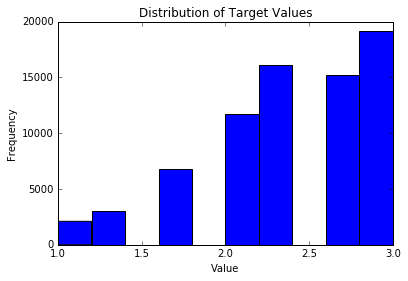

In [34]:
print "Target Mean: %.2f, Target std: %.2f \n" % (trainData.relevance.mean(), trainData.relevance.std())

plt.hist(trainData['relevance'], align = 'mid')
plt.title("Distribution of Target Values")
plt.xlabel("Value")
plt.ylabel("Frequency")

## Data Manipulation 

We have a number of sources of descriptive data that relate to each product. However, various grammatical and formatting errors can significantly weaken the effectiveness of this data. <br>
From our exploratory exercise above, we notice **Product Descriptions** are missing spaces that combine two sentences as one. It appears that each of those "merged" sentences are the bullet points from the **Attributes**, so we search for the beginning and end of each of these bullet points in the product description and insert a space between them. We also extract the "brand name" attribute so that we can add it into a "combined product description" we'll create later. <br>
***You can skip the Data Manipulation section if you have both of the "cosine" files for Train and Test sets (TrainDataCosine.csv and testDFCosineSimilarity.csv)***

In [17]:
#Since the product description file has poorly spaced sentences (ie. Run-on sentences that represent
#the attribute bullet points)
#We are going to find the first word of each bullet for each product and apply a space in front of that word
#in the product description page
bulletPoints = attributes[attributes.name.str.contains('Bullet')== True]

#for each row of product descriptions, add in the spaces with the run on sentences
prodDesc.product_description = prodDesc.apply(addSpaces, axis = 1)
        
#Drop every other attribute except the Brand Name
attributes = attributes[attributes.name.str.contains('MFG Brand Name')==True]

#Combine the remaining attribute categories (attribute names are combined with attribute details, to preserve
# knowledge of the types of attributes we've decided to keep
#attributes['combined'] = attributes.name.str.cat(attributes.value, sep = ' ')

#convert the 'combined' attribute descriptions into String type
attributes['name'] = attributes['name'].astype('str')

In [18]:
#merge our Product Descriptions DF with the Attributes DF, based on common Product IDs
mergedProdDesc = prodDesc.merge(attributes, how = 'left', on = 'product_uid')
#fill in the NaNs for the products that didn't have a brand name in their attributes section
mergedProdDesc.value.fillna('', inplace = True)

# "Product Descriptions" are combined with their "attributes" into one single column of text
#this continues to grow our 'bag of words' for each product
mergedProdDesc['complete_description'] = mergedProdDesc.product_description.str.cat(mergedProdDesc.value.str.lstrip(), sep = ' ')

#get rid of the individual columns now that our description details are combined
#mergedProdDesc.drop(['product_description','attributes'], axis = 1, inplace = True)


From one of the Kaggle forums, I learned about a generic spell correction algorithm posted by Peter Norvig on http://norvig.com/spell-correct.html <br>
It uses a probability based approach of finding the "correct" version of an input word from of a large set of "corrected" words that we create having an **edit distance** of 1 and 2 from the original input word.

In [38]:
#Source:http://norvig.com/spell-correct.html
def words(text): 
    returnSet = []
    for item in text:
        returnSet += re.findall('[a-z]+', item.lower())
    return returnSet

def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model

#NWORDS = train(words())

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [a + b[1:] for a, b in splits if b]
    transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
    replaces   = [a + c + b[1:] for a, b in splits for c in alphabet if b]
    inserts   = [a + c + b     for a, b in splits for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)

def known(words): return set(w for w in words if w in NWORDS)

def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return max(candidates, key=NWORDS.get)

In [39]:
# The spell-check algorithm above relies on a "universe of words" that we use to compare our potential corrections
startTime = time.time()
print "Creating word dictionary"
NWORDS = train(words(mergedProdDesc.complete_description))
print "Cleaning word dict took: %r minutes" % ((time.time()-startTime)/60)

Creating word dictionary
Cleaning word dict took: 0.14110626777013144 minutes


We assume the product descriptions and attributes provided to us are spelled correctly. Therefore, we only correct the customer's search terms. <br>
Next, we use a 7-step "cleanText" process that will help create more uniform text which is more conducive for modeling.

In [48]:
#clean all the text that you've combined for each product
startTime = time.time()
print "Spell Checking"
trainData.search_term = trainData.search_term.apply(lambda x: spellCheck(x))
testData.search_term = testData.search_term.apply(lambda x: spellCheck(x))
print "Cleaning text"
mergedProdDesc.complete_description = mergedProdDesc.complete_description.apply(lambda x: cleanText(x))
trainData.search_term = trainData.search_term.apply(lambda x: cleanText(x))
testData.search_term = testData.search_term.apply(lambda x: cleanText(x))
print "Cleaning text took: %r minutes" % ((time.time()-startTime)/60)

Spell Checking
Cleaning text
Cleaning text took: 51.0881606499354 minutes


In [49]:
#Take the product descriptions and attach them to each of the Test data elements
cleanTrain = trainData.merge(mergedProdDesc, how = 'left', on = 'product_uid' )
#Take the product descriptions and attach them to each of the Test data elements
cleanTest = testData.merge(mergedProdDesc, how = 'left', on = 'product_uid' )

Now that we've cleaned up and amalgamated all of our relevant product descriptions, we are going to create our **Bag of words** model using **TF-IDF (Term Frequency - Inverse Document Frequency)**. TF-IDF creates a matrix of all words that exist in the "universe of documents" you provide, and weights the word counts in such a way as to give greater weight to words that have a higher frequency, but appear in fewer documents. (The logic behind this being that if a word appears in most, if not all, of the documents, then we don't gain very much knowledge from it.) <br>
We will use n-grams, with n= 1 to 3. **n-grams** creates combinations of every "n" consecutive words, and treats them as 'one word' for the sake of creating the bag-of-words. This way we gain more knowledge through context, instead of just looking at the individual words.

In [50]:
vectorizer = TfidfVectorizer( ngram_range =(1,3))

startTime = time.time()
docMatrix = vectorizer.fit_transform(mergedProdDesc.complete_description)

searchTrain = vectorizer.transform(cleanTrain.search_term)
descriptionTrain = vectorizer.transform(cleanTrain.complete_description)

searchTest = vectorizer.transform(cleanTest.search_term)
descriptionTest = vectorizer.transform(cleanTest.complete_description)

print "TF-IDF vectorizer took: %r minutes" % ((time.time()-startTime)/60)


TF-IDF vectorizer took: 4.367673599720002 minutes


Since we will no doubt have a very large dictionary of words in our bag-of-words matrix, we now have to consider the possibility of high-dimensionality in our data. <br>
From a previous Kaggle winner of a natural language processing competition, I learned they had used Singular Vector Decomposition (SVD) in order to reduce dimensionality. A very high level intuition behind this concept is to take a rank reduced approximation of an original dataset matrix, while attempting to maintain the general properties and structure (keep just enough data such that you can still maintain the identity of what you originally started with).

In [51]:
#Use Singular vector decomposition to reduce the dimensionality of the terms we've collected from the complete
#product descriptions

startTime = time.time()
SVD = TruncatedSVD(n_components = 100)

docMatrix = SVD.fit_transform(docMatrix)
searchTrain = SVD.transform(searchTrain)
descriptionTrain = SVD.transform(descriptionTrain)

searchTest = SVD.transform(searchTest)
descriptionTest = SVD.transform(descriptionTest)

print "Trunc SVD took: %r minutes" % ((time.time()-startTime)/60)

Trunc SVD took: 59.09447696606318 minutes


The first feature we will be adding to our Train and Test dataframes is the **Cosine Similarity**. Cosine Similarity measures the similarity between two vectors of data (in our case, text), ranging from -1 (opposite direction) to +1 (same direction). SKLearn has conveniently provided us with an implementation of this function.

In [58]:
# calculate how "related" the search term is to the complete production decription using Cosine Similarity
# for TRAINING DATA
cosineMatrix = []
for myElement in xrange(searchTrain.shape[0]):
    cosineMatrix.append(float(cosine_similarity(searchTrain[myElement,:].reshape(1,-1), 
                                                descriptionTrain[myElement,:].reshape(1,-1))))
cleanTrain['cosineSimilarity'] = cosineMatrix
cleanTrain.to_csv('data/cleanTrain.csv', index = False)


# calculate how "related" the search term is to the complete production decription using Cosine Similarity
# for TEST DATA
cosineMatrix = []
for myElement in xrange(searchTest.shape[0]):
    cosineMatrix.append(float(cosine_similarity(searchTest[myElement,:].reshape(1,-1), 
                                                descriptionTest[myElement,:].reshape(1,-1))))

# create a new column in the Test Dataframe that records the Cosine Similarity score for each searchTerm vs. 
# ProdDescrition     
cleanTest['cosineSimilarity'] = cosineMatrix

#save down the work into a new file so that we can simply import CSV file for future work instead of re-running all
cleanTest.to_csv('data/cleanTest.csv', index = False)

## Modeling the data

While there are only three values that can be assigned to the 'relevance' of search-terms/product combinations, we don't know exactly how many human evaluators are being used and therefore don't know exactly how many outcomes we're predicting. We naturally think about a regression based process, given the seemingly open-endedness of our task. <br>
**Linear regression** - very simple and fairly quick model that can allow us to scale up our complexity as desired and allowing us to make a broad range of predictions. The drawback, however, is that we may predict a value above or below our limits. <br>

We also consider: <br>
**Random Forest** - Allows us to utilize the multiple boundary decision-making process of a decision tree but reduce variance. Variance reduction is done through using many DTs (Ensemble method), each tree using a random subset of training points with replacement (Bagging method), and each tree uses randomly selected features upon which to base our decision boundaries on. 

**Extremely Randomized Trees (Extra Trees)** - Same as a Random Forest classifier, except that for each feature used in  the decision boundaries, the split value is randomly chosen from that features empirical range.

**Gradient Boosting**. - Going one step further, Gradient boosting combines a series of weak learners (for example, the various tree based learners described above), and with each iterative step adds another learner to correct the errors generated from the prior learners. 

While most of the models we'll implement are part of the SKLearn package, we will also use the **XGBoost** package. XGBoost (Extreme Gradient Boosting) is an optimized, efficient and very accurate implementation of the Gradient Boosting model that has gained notoriety as being a model of choice in many winning Kaggle competitions. 

Our objective was to minimize the **Root Mean Squared Error**: <br>
$$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$


This is the point from which I begin work again after doing the computation intensive work above. <br>
Let's create two more features that might be useful in gaining knowledge. How much of a product's title is present in the search terms and vice versa? <br>

In [19]:
#************************************
#Continue from here: After you've read in or created the cleanTrain/cleanTest dataframe
#************************************

#scrub the product title
cleanTrain.product_title = cleanTrain.product_title.apply(lambda x: cleanText(x))

#Calculate what proportion of the given element is present in the other 
# ie. how many search words are present in product title and how many prod title words are in search term
cleanTrain['prodWordMatch'], cleanTrain['searchWordMatch'] = zip(*cleanTrain.apply(compareWordHits, axis = 1))

#do the same two-step process for the training set as well
cleanTest.product_title = cleanTest.product_title.apply(lambda x: cleanText(x))
cleanTest['prodWordMatch'], cleanTest['searchWordMatch'] = zip(*cleanTest.apply(compareWordHits, axis = 1))

/Users/ankitpatel/anaconda/lib/python2.7/site-packages/nltk/stem/porter.py:274: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if word[-1] == 's':


Let's start by trying out a few of the models we're considering and see how they fair, using default parameter settings. <br>
We can see that the ExtraTrees regressor was the poorest performing model, while XGBoost was the best performing one. 

In [20]:
###########################
xData = cleanTrain[['cosineSimilarity','prodWordMatch','searchWordMatch']].values
yData = cleanTrain['relevance'].values
xTest = cleanTest[['cosineSimilarity','prodWordMatch','searchWordMatch']].values
###########################

models =[LinearRegression(),
         XGBRegressor(max_depth = 5, n_estimators = 100, reg_alpha = 1, reg_lambda = 4),
         RandomForestRegressor(n_estimators=100, random_state = 0),
         ExtraTreesRegressor(n_estimators=100, random_state = 0),
         GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, random_state = 0),
         AdaBoostRegressor(n_estimators = 100, random_state = 0, learning_rate = 0.1)]

for model in models:
    print "model %s:, score: %r" %(model, cv_score(model,xData, yData ))

model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False):, score: 0.501030505182299
model XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=1, reg_lambda=4,
       scale_pos_weight=1, seed=0, silent=True, subsample=1):, score: 0.49206259309577255
model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False):, score: 0.5452820483919778
model ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2

Let's stay with the XGBoost model for the moment. We will use the GridSearch function from SKLearn to test a number of different parameter values to find the best combination that optimizes our scoring function. 


In [27]:
# params to be fine tuned on XGB

# set up a basic XGB model, with some params that i've already tested before
XGB = XGBRegressor(learning_rate = .1)

params = {'max_depth': [4,5,6], 'n_estimators': [50,100,200]}

xData = cleanTrain[['cosineSimilarity','prodWordMatch','searchWordMatch']].values
yData = cleanTrain['relevance'].values
XGBgridSearch, gridScores, bestParams, bestScore = do_GridsearchCV(XGB, params, RootMSE, xData, yData)

Training Accuracy: -0.48
[mean: -0.49278, std: 0.00737, params: {'n_estimators': 50, 'max_depth': 4}, mean: -0.49248, std: 0.00864, params: {'n_estimators': 100, 'max_depth': 4}, mean: -0.49239, std: 0.00864, params: {'n_estimators': 200, 'max_depth': 4}, mean: -0.49249, std: 0.00747, params: {'n_estimators': 50, 'max_depth': 5}, mean: -0.49224, std: 0.00881, params: {'n_estimators': 100, 'max_depth': 5}, mean: -0.49251, std: 0.00880, params: {'n_estimators': 200, 'max_depth': 5}, mean: -0.49263, std: 0.00762, params: {'n_estimators': 50, 'max_depth': 6}, mean: -0.49260, std: 0.00892, params: {'n_estimators': 100, 'max_depth': 6}, mean: -0.49318, std: 0.00873, params: {'n_estimators': 200, 'max_depth': 6}] {'n_estimators': 100, 'max_depth': 5} -0.492243407826

Time GridSearchCV took to run: 1.6327219168345133 minutes


In [29]:
# print out what my best parameter value combination is as well as the resulting score
print bestParams
print bestScore

{'n_estimators': 100, 'max_depth': 5}
-0.492243407826


In [30]:
# using the best parameters found, re-train the XGB model and predict outcomes on test set
XGB = XGBRegressor(max_depth = 5, n_estimators = 100, learning_rate = .1)

xData = cleanTrain[['cosineSimilarity','prodWordMatch','searchWordMatch']].values
yData = cleanTrain['relevance'].values
xTest = cleanTest[['cosineSimilarity','prodWordMatch','searchWordMatch']].values
XGB.fit(xData, yData)

yPred = XGB.predict(xTest)

# Assign our predictions to the sample submission format
sampleSubmission.relevance = yPred

# make sure nothing looks weird
sampleSubmission.head()


,id,relevance
0,1,1.960649
1,4,1.907297
2,5,2.383601
3,6,2.377937
4,7,2.229343


In [31]:
# write the predictions to a csv file that can be uploaded to Kaggle
# file name has current data and time appended to it, so different predictions can be distinguished 

writePath = 'data/XGB_prob_submission_%s.csv' % (datetime.datetime.now())
#sampleSubmission.to_csv(writePath, index = False)

## Blending Models

One of the methods commonly seen in Kaggle competitions is the use of Ensembling and/or Stacking. <br>
Ensembling tends to describe the process of training multiple models, who's individual predictions are weighted in some fashion, subsequently producing one collective prediction. <br>
Stacking, on the other hand, trains multiple models, makes predictions using those models, and then trains *another* model on those predictions, ultimately using this combiner model to make a final set of predictions. <br>
The intuition behind using these approaches is that we can 'learn' from the different 'opinions' provided by a group of models, which may not be very strong individually, but collectively can be more effective in choosing an accurate prediction (kind of a "people's choice", without significant group think).

In [32]:
#Try a model blending approach
#Much of this code sourced from: https://github.com/emanuele/kaggle_pbr/blob/master/blend.py

###########################
X = cleanTrain[['cosineSimilarity','prodWordMatch','searchWordMatch']].values
y = cleanTrain['relevance'].values
X_submission = cleanTest[['cosineSimilarity','prodWordMatch','searchWordMatch']].values
###########################

n_folds = 10  #use 10 folds in our cross-validation model building below

skf = list(StratifiedKFold(y, n_folds)) # stratifiedKFold provides train/test sets for n_fold iterations, 
                                        # while maintaining the class proportions of the original target set

# our set of base learners (models)
clfs =[LinearRegression(),
         XGBRegressor(max_depth = 5, n_estimators = 100, learning_rate = 0.1),
         RandomForestRegressor(n_estimators=100, random_state = 0),
         ExtraTreesRegressor(n_estimators=100, random_state = 0),
         GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, random_state = 0),
         AdaBoostRegressor(n_estimators = 100, random_state = 0, learning_rate = 0.1)]


print "Creating train and test sets for blending."
start_time = time.time()
#######################################
# dataset_blend_train - matrix of (# training samples, # of clfs). It collects all of the predictions made on  
#                       'held out' chunks of test sets during the CV process, for each model in our list
# dataset_blend_test - matrix of (# of test samples, # of clfs). Collects the average of 10 folds of predictions
#                      made on the actual test data; for each model in our list.
#######################################
dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_submission.shape[0], len(clfs)))
    
for j, clf in enumerate(clfs):
    print j, clf  #print classifier number and model info
    dataset_blend_test_j = np.zeros((X_submission.shape[0], len(skf)))  #matrix to hold our predictions on the actual
                                                                        #final test set for each fold 'i'
    #for each fold 'i', do work with the train/test set created
    for i, (train, test) in enumerate(skf):
        print "Fold", i
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict(X_test)
        dataset_blend_train[test, j] = y_submission  #predictions made on our skf test set are added to the train matrix
                                                     #in their respective test rows assigned by skf
        dataset_blend_test_j[:, i] = clf.predict(X_submission) #predictions made on our actual test data
                                                                          #assigned to matrix for each fold  
    dataset_blend_test[:,j] = dataset_blend_test_j.mean(1)  #in the overall test matrix, assign the average
                                                            #prediction of all i folds on the actual test data
                                                            #for each classifier 'j' in our list

    # The predictions of the original training set are your new train set
    # The average of all predictions of the original test set are your new input test set
    
print "Blending."

# our final "combiner" model 
clf = LinearRegression()

# "train on predictions, and make predictions on predictions"
clf.fit(dataset_blend_train, y)  #train combiner model on the predictions made on the training data by each base model
y_submission = clf.predict(dataset_blend_test) #predict outcome given the averaged test predictions of each
                                                          #base model

#do an independent, local cross-validation to see what the final results might score 
score = cv_score(clf,dataset_blend_train, y )
print "***Score*** ", score

# if i've beaten my benchmark score, then I'm going to save my current results down to csv for Kaggle submission
benchmark_score = 0.50
if score < benchmark_score:
    sampleSubmission.relevance = y_submission
    print "Saving to file."
    writePath = 'submissions/Blended_submission_%s.csv' % (datetime.datetime.now())
    sampleSubmission.to_csv(writePath, index = False)

    
print "Total time taken: %r minutes" % ((time.time()-start_time)/60) 

Creating train and test sets for blending.
0 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
1 XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
2 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
3 ExtraTreesRegresso

/Users/ankitpatel/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Taking a quick look at the distribution of the final set of predictions:

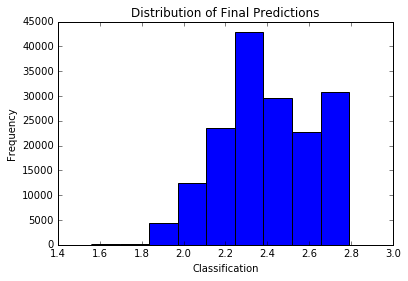

In [33]:
plt.hist(y_submission, align = 'mid')
plt.title("Distribution of Final Predictions")
plt.xlabel("Classification")
plt.ylabel("Frequency")

## Final thoughts

From our basic modeling to the more complex stacked model, we didn't really see a significant gain in performance. We can see that our predictions don't have a similar distribution as the training data. Our predictions are rather clustered in the mid 2 range, whereas the training data seemed to be clustered more around the individual classes (1, 2, and 3). This doesn't bode too well for our modeling and is reflected in our local cv score. <br>
To improve our results, we probably would need to improve/increase our feature space quite a bit. We only created/used three features, while reading through the Kaggle forums other folks seemed to have many more. <br>
Another common issue that was spoken of in the forums, was the correction of spelling mistakes in the search terms. There was a dictionary of search term corrections that was publicly posted, which was obtained by someone who created a script using Google search calls and utlized the "did you mean" spell-checked suggestions. I opted to try to find a more generic algorithm. Maybe the next step would be to check to see if those provided spelling corrections would've indeed made a bigger difference.